In [1]:
import pyiqa
import math
import io
import torch
from torchvision import transforms
import numpy as np

from PIL import Image

import matplotlib.pyplot as plt
from pytorch_msssim import ms_ssim
from compressai.zoo import cheng2020_anchor
from ipywidgets import interact, widgets
import torch
import torch.nn as nn
from torch.nn import functional as F
from compressai.models.waseda import Cheng2020Anchor
from compressai.models.google import JointAutoregressiveHierarchicalPriors
from compressai.layers import (
    AttentionBlock,
    ResidualBlock,
    ResidualBlockUpsample,
    ResidualBlockWithStride,
    conv3x3,
    subpel_conv3x3
)
# import warnings
from torchsummary import summary
from compressai.optimizers import net_aux_optimizer
from pytorch_msssim import ms_ssim
import glob
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
from pathlib import Path
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
import torch.optim as optim
import shutil
import os
import tqdm
from compressai.zoo import image_models
import cv2
from skimage.util import random_noise

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
class FlexLatLIC(JointAutoregressiveHierarchicalPriors):

    def __init__(self, quality = 1, **kwargs):
        quality_list = {
        1: 128,
        2: 128,
        3: 128,
        4: 192,
        5: 192,
        6: 192,
        }
        N = quality_list[quality]
        super().__init__(N=N, M=N, **kwargs)

        self.g_a_distortion = nn.Sequential(
            ResidualBlockWithStride(3, N, stride=2),
            ResidualBlock(N, N),
            ResidualBlockWithStride(N, N, stride=2),
            ResidualBlock(N, N),
            ResidualBlockWithStride(N, N, stride=2),
            ResidualBlock(N, N),
            conv3x3(N, N, stride=2),
        )

        self.g_a_clear = nn.Sequential(
            ResidualBlockWithStride(3, N, stride=2),
            ResidualBlock(N, N),
            ResidualBlockWithStride(N, N, stride=2),
            ResidualBlock(N, N),
            ResidualBlockWithStride(N, N, stride=2),
            ResidualBlock(N, N),
            conv3x3(N, N, stride=2),
        )

        self.h_a = nn.Sequential(
            conv3x3(N, N),
            nn.LeakyReLU(inplace=True),
            conv3x3(N, N),
            nn.LeakyReLU(inplace=True),
            conv3x3(N, N, stride=2),
            nn.LeakyReLU(inplace=True),
            conv3x3(N, N),
            nn.LeakyReLU(inplace=True),
            conv3x3(N, N, stride=2),
        )

        self.h_s = nn.Sequential(
            conv3x3(N, N),
            nn.LeakyReLU(inplace=True),
            subpel_conv3x3(N, N, 2),
            nn.LeakyReLU(inplace=True),
            conv3x3(N, N * 3 // 2),
            nn.LeakyReLU(inplace=True),
            subpel_conv3x3(N * 3 // 2, N * 3 // 2, 2),
            nn.LeakyReLU(inplace=True),
            conv3x3(N * 3 // 2, N * 2),
        )

        self.g_s_distortion = nn.Sequential(
            ResidualBlock(N, N),
            ResidualBlockUpsample(N, N, 2),
            ResidualBlock(N, N),
            ResidualBlockUpsample(N, N, 2),
            ResidualBlock(N, N),
            ResidualBlockUpsample(N, N, 2),
            ResidualBlock(N, N),
            subpel_conv3x3(N, 3, 2),
        )

        self.g_s_clear = nn.Sequential(
            ResidualBlock(N, N),
            ResidualBlockUpsample(N, N, 2),
            ResidualBlock(N, N),
            ResidualBlockUpsample(N, N, 2),
            ResidualBlock(N, N),
            ResidualBlockUpsample(N, N, 2),
            ResidualBlock(N, N),
            subpel_conv3x3(N, 3, 2),
        )

        self.g_s = nn.Sequential(
            ResidualBlock(N, N),
            ResidualBlockUpsample(N, N, 2),
            ResidualBlock(N, N),
            ResidualBlockUpsample(N, N, 2),
            ResidualBlock(N, N),
            ResidualBlockUpsample(N, N, 2),
            ResidualBlock(N, N),
            subpel_conv3x3(N, 3, 2),
        )

        self.maxPool =  torch.nn.MaxPool3d((2,1,1),stride=(2,1,1))

    def forward(self, x, alpha=0.5):
        y_distortion = self.g_a_distortion(x)
        y_clear = self.g_a_clear(x)
        y_hat_distortion = self.gaussian_conditional.quantize(
            y_distortion, "noise" if self.training else "dequantize"
        )
        y_hat_clear = self.gaussian_conditional.quantize(
            y_clear, "noise" if self.training else "dequantize"
        )

        y = (1-alpha)*y_clear + (alpha*y_distortion)
        # y_clear_pool = self.maxPool(y_clear)
        # y_distortion_pool = self.maxPool(y_distortion)    
        # y = torch.cat((y_clear_pool,y_distortion_pool),1)
        
        z = self.h_a(y)
        
        z_hat, z_likelihoods = self.entropy_bottleneck(z)
        params = self.h_s(z_hat)

        y_hat = self.gaussian_conditional.quantize(
            y, "noise" if self.training else "dequantize"
        )
        ctx_params = self.context_prediction(y_hat)
        gaussian_params = self.entropy_parameters(
            torch.cat((params, ctx_params), dim=1)
        )
        scales_hat, means_hat = gaussian_params.chunk(2, 1)
        _, y_likelihoods = self.gaussian_conditional(y, scales_hat, means=means_hat)
        
        x_hat = self.g_s(y_hat)
        x_hat_distortion = self.g_s_distortion(y_hat_distortion)
        x_hat_clear = self.g_s_clear(y_hat_clear)

        return {
            "x_hat": x_hat,
            "x_hat_clear": x_hat_clear,
            "x_hat_distortion": x_hat_distortion,
            "y_hat": y_hat,
            "likelihoods": {"y": y_likelihoods, "z": z_likelihoods},
        }
        

In [4]:
def compute_psnr(a, b):
    mse = torch.mean((a - b)**2).item()
    return -10 * math.log10(mse)

def compute_msssim(a, b):
    return ms_ssim(a, b, data_range=1.).item()

def compute_bpp(out_net):
    size = out_net['x_hat'].size()
    num_pixels = size[0] * size[2] * size[3]
    return sum(torch.log(likelihoods).sum() / (-math.log(2) * num_pixels)
              for likelihoods in out_net['likelihoods'].values()).item()

def compute_niqe(a, b):
    return ms_ssim(a, b, data_range=1.).item()

In [5]:
inputs= {
    'proposed_method (alpha=0.1)':{
        'root_dir':'/home/milkyway/Universe/nebulas/JpegAI/CompressAI/our3_mse',
        'quality':[1,2,3,4,5,6],
        'alpha':0.1
    },
    'proposed_method (alpha=0.3)':{
        'root_dir':'/home/milkyway/Universe/nebulas/JpegAI/CompressAI/our3_mse',
        'quality':[1,2,3,4,5,6],
        'alpha':0.3
    },
    'proposed_method (alpha=0.5)':{
        'root_dir':'/home/milkyway/Universe/nebulas/JpegAI/CompressAI/our3_mse',
        'quality':[1,2,3,4,5,6],
        'alpha':0.5
    },
    'proposed_method (alpha=0.7)':{
        'root_dir':'/home/milkyway/Universe/nebulas/JpegAI/CompressAI/our3_mse',
        'quality':[1,2,3,4,5,6],
        'alpha':0.7
    },
    'proposed_method (alpha=0.9)':{
        'root_dir':'/home/milkyway/Universe/nebulas/JpegAI/CompressAI/our3_mse',
        'quality':[1,2,3,4,5,6],
        'alpha':0.9
    },
    'balle2018':{
        'name': 'bmshj2018-hyperprior',
        'root_dir':'models/bmshj2018/mse',
        'quality':[1,2,3,4,5,6]
    },
    'minnen2018':{
        'name': 'mbt2018-mean',
        'root_dir':'models/mbt/mse',
        'quality':[1,2,3,4,5,6]
    },
    'cheng2020':{
        'name': 'cheng2020-attn',
        'root_dir':'models/cheng_att/mse',
        'quality':[1,2,3,4,5,6]
    },
}

In [12]:
device = 'cuda'
data_path = glob.glob("/home/milkyway/Universe/nebulas/JpegAI/kodak/*")

In [13]:
img_noise = np.array(img_noise*255, dtype=np.uint8)
cv2.imwrite('results/out_input.png',img_noise)

NameError: name 'img_noise' is not defined

True

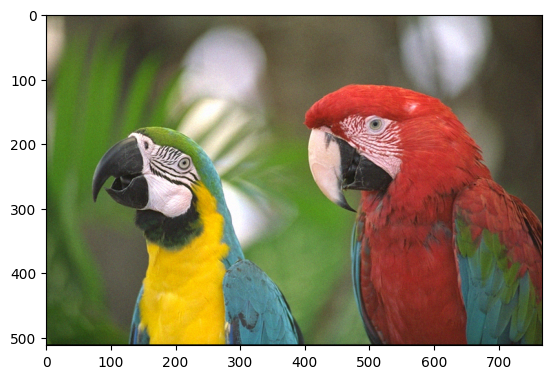

In [17]:
img_path = data_path[7]
# img = Image.oimg = Image.open(img_path).convert('RGB')
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
sigma = 0.02
img_noise = random_noise(img,mode='gaussian',var=sigma**2,mean=0)
img_noise = np.array(img_noise, dtype=np.float32)
cv2.imwrite('results/out_input.png',img_noise)
x_ref = transforms.ToTensor()(img).unsqueeze(0).to(device)   
# x_ref = transforms.RandomCrop(size=(128, 128))(x_ref)
x = transforms.ToTensor()(img_noise).unsqueeze(0).to(device)   
# x = transforms.RandomCrop(size=(128, 128))(x)

plt.imshow(img_noise)

qu = 1
check_path = os.path.join('/home/milkyway/Universe/nebulas/JpegAI/CompressAI/our3_mse', 'q'+str(qu), "checkpoint.pth.tar")
checkpoint = torch.load(check_path)
net = FlexLatLIC(quality=qu)
net.load_state_dict(checkpoint['state_dict'])
net = net.to(device).eval()


rv = net(x,0.5)
rv['x_hat'].clamp_(0, 1)
out_net = rv
out_img = out_net["x_hat"][0].detach().cpu()
out_img = np.array(255*out_img.permute(1, 2, 0).numpy(), dtype=np.uint8)
out_img = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
cv2.imwrite('results/out_base_cfg.png',out_img)

rv = net(x,0.3)
rv['x_hat'].clamp_(0, 1)
out_net = rv
out_img = out_net["x_hat"][0].detach().cpu()
out_img = np.array(255*out_img.permute(1, 2, 0).numpy(), dtype=np.uint8)
out_img = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
cv2.imwrite('results/out_03_dst.png',out_img)

rv = net(x,0.7)
rv['x_hat'].clamp_(0, 1)
out_net = rv
out_img = out_net["x_hat"][0].detach().cpu()
out_img = np.array(255*out_img.permute(1, 2, 0).numpy(), dtype=np.uint8)
out_img = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
cv2.imwrite('results/out_07_dst.png',out_img)

# cheng_net = cheng2020_anchor(quality=qu, pretrained=True).eval()
# g_s_clear = cheng_net.g_s
# for param in g_s_clear.parameters():
#     param.requires_grad = False   
# g_s_clear.to(device)
# x_hat_clear = g_s_clear(out_net["x_hat_clear"])
# x_hat_clear = x_hat_clear[0]
# x_hat_clear = np.array(255*x_hat_clear.permute(1, 2, 0).detach().cpu().numpy(), dtype=np.uint8)
# x_hat_clear = cv2.cvtColor(x_hat_clear, cv2.COLOR_BGR2RGB)
# cv2.imwrite('results/x_hat_clear.png',x_hat_clear)

# rv = net(x,0.5)
# rv['x_hat'].clamp_(0, 1)
# out_net1 = rv
# out_img1 = out_net1["x_hat"][0].detach().cpu()
# out_img1 = np.array(255*out_img1.permute(1, 2, 0).numpy(), dtype=np.uint8)
# out_img1 = cv2.cvtColor(out_img1, cv2.COLOR_BGR2RGB)
# cv2.imwrite('results/out0_5.png',out_img1)

# rv = net(x,0.2)
# rv['x_hat'].clamp_(0, 1)
# out_net0 = rv
# out_img0 = out_net0["x_hat"][0].detach().cpu()
# out_img0 = np.array(255*out_img0.permute(1, 2, 0).numpy(), dtype=np.uint8)
# out_img0 = cv2.cvtColor(out_img0, cv2.COLOR_BGR2RGB)
# cv2.imwrite('results/out0.png',out_img0)

In [8]:
# print(compute_psnr(x_ref,out_net["x_hat"][0]))
# print(compute_psnr(x_ref,out_net2["x_hat"][0]))

In [7]:
model_report = {}
niqe_loss = pyiqa.create_metric('niqe', device=device)
iqa_loss = pyiqa.create_metric('lpips', device=device)
tres_loss = pyiqa.create_metric('tres', device=device)


for model_name in inputs:
    model_report[model_name] = {}
    for quality in inputs[model_name]['quality']:
        model_report[model_name][quality] = {}
        images_bpp = []
        images_psnr = []
        images_ssim = []
        images_lpips = []
        images_niqe = []
        images_tres = []

        if 'proposed_method' not in model_name :
            print(model_name,' ',quality)
            net = image_models[inputs[model_name]['name']](quality=quality)
        else:
            print('proposed model','/',inputs[model_name]['alpha'],' ',quality)
            net = FlexLatLIC(quality=quality)
        
        check_path = os.path.join(inputs[model_name]['root_dir'], 'q'+str(quality), "checkpoint.pth.tar")
        checkpoint = torch.load(check_path)
        print(checkpoint["epoch"])
        net.load_state_dict(checkpoint['state_dict'])
        net = net.to(device).eval()
        
        
        for img_path in tqdm.tqdm(data_path):
            # Read and transform input image
            # img = Image.oimg = Image.open(img_path).convert('RGB')
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            sigma = 0.5
            img_noise = random_noise(img,mode='gaussian',var=sigma**2,mean=0)
            img_noise = np.array(img_noise, dtype=np.float32)
            x_ref = transforms.ToTensor()(img).unsqueeze(0).to(device)   
            x = transforms.ToTensor()(img_noise).unsqueeze(0).to(device)    
 
            
            # inference
            with torch.no_grad():
                if 'proposed_method' not in model_name :
                    rv = net(x)
                else:
                    rv = net(x,inputs[model_name]['alpha'])
                rv['x_hat'].clamp_(0, 1)
                out_net = rv
            
            # compute bpp
            bpp = compute_bpp(out_net)
            images_bpp.append(bpp)
            
            cur_psnr = compute_psnr(x_ref, out_net["x_hat"])
            cur_lpips = iqa_loss(x_ref, out_net["x_hat"]).detach().cpu().numpy()
            cur_tres = tres_loss(out_net["x_hat"]).detach().cpu().numpy()
            cur_niqe = niqe_loss(out_net["x_hat"]).detach().cpu().numpy()
            cur_ssim = compute_msssim(x_ref, out_net["x_hat"])
            
            images_psnr.append(cur_psnr)
            images_lpips.append(cur_lpips)
            images_niqe.append(cur_niqe)
            images_tres.append(cur_tres)
            images_ssim.append(cur_ssim)

        
        model_report[model_name][quality]['images_bpp'] = np.mean(images_bpp)
        model_report[model_name][quality]['images_psnr'] = np.mean(images_psnr)
        model_report[model_name][quality]['images_ssim'] = np.mean(images_ssim)
        model_report[model_name][quality]['images_lpips'] = np.mean(images_lpips)
        model_report[model_name][quality]['images_tres'] = np.mean(images_tres)
        model_report[model_name][quality]['images_niqe'] = np.mean(images_niqe)


            

Loading pretrained model LPIPS from /home/milkyway/.cache/torch/hub/checkpoints/LPIPS_v0.1_alex-df73285e.pth
Loading pretrained model TReS from /home/milkyway/.cache/torch/hub/checkpoints/tres_koniq-f0502926.pth
proposed model / 0.1   1
599


100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


proposed model / 0.1   2
599


100%|██████████| 24/24 [00:14<00:00,  1.67it/s]


proposed model / 0.1   3
599


100%|██████████| 24/24 [00:14<00:00,  1.67it/s]


proposed model / 0.1   4
599


100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


proposed model / 0.1   5
599


100%|██████████| 24/24 [00:16<00:00,  1.43it/s]


proposed model / 0.1   6
599


100%|██████████| 24/24 [00:16<00:00,  1.43it/s]


proposed model / 0.3   1
599


100%|██████████| 24/24 [00:14<00:00,  1.67it/s]


proposed model / 0.3   2
599


100%|██████████| 24/24 [00:14<00:00,  1.67it/s]


proposed model / 0.3   3
599


100%|██████████| 24/24 [00:14<00:00,  1.67it/s]


proposed model / 0.3   4
599


100%|██████████| 24/24 [00:16<00:00,  1.44it/s]


proposed model / 0.3   5
599


100%|██████████| 24/24 [00:16<00:00,  1.43it/s]


proposed model / 0.3   6
599


100%|██████████| 24/24 [00:16<00:00,  1.44it/s]


proposed model / 0.5   1
599


100%|██████████| 24/24 [00:14<00:00,  1.68it/s]


proposed model / 0.5   2
599


100%|██████████| 24/24 [00:14<00:00,  1.68it/s]


proposed model / 0.5   3
599


100%|██████████| 24/24 [00:14<00:00,  1.68it/s]


proposed model / 0.5   4
599


100%|██████████| 24/24 [00:16<00:00,  1.43it/s]


proposed model / 0.5   5
599


100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


proposed model / 0.5   6
599


100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


proposed model / 0.7   1
599


100%|██████████| 24/24 [00:14<00:00,  1.68it/s]


proposed model / 0.7   2
599


100%|██████████| 24/24 [00:14<00:00,  1.68it/s]


proposed model / 0.7   3
599


100%|██████████| 24/24 [00:14<00:00,  1.68it/s]


proposed model / 0.7   4
599


100%|██████████| 24/24 [00:16<00:00,  1.44it/s]


proposed model / 0.7   5
599


100%|██████████| 24/24 [00:16<00:00,  1.44it/s]


proposed model / 0.7   6
599


100%|██████████| 24/24 [00:16<00:00,  1.44it/s]


proposed model / 0.9   1
599


100%|██████████| 24/24 [00:14<00:00,  1.67it/s]


proposed model / 0.9   2
599


100%|██████████| 24/24 [00:14<00:00,  1.68it/s]


proposed model / 0.9   3
599


100%|██████████| 24/24 [00:14<00:00,  1.68it/s]


proposed model / 0.9   4
599


100%|██████████| 24/24 [00:16<00:00,  1.44it/s]


proposed model / 0.9   5
599


100%|██████████| 24/24 [00:16<00:00,  1.44it/s]


proposed model / 0.9   6
599


100%|██████████| 24/24 [00:16<00:00,  1.42it/s]


balle2018   1
599


100%|██████████| 24/24 [00:12<00:00,  1.93it/s]


balle2018   2
599


100%|██████████| 24/24 [00:12<00:00,  1.94it/s]


balle2018   3
599


100%|██████████| 24/24 [00:12<00:00,  1.99it/s]


balle2018   4
599


100%|██████████| 24/24 [00:12<00:00,  2.00it/s]


balle2018   5
599


100%|██████████| 24/24 [00:12<00:00,  1.94it/s]


balle2018   6
599


100%|██████████| 24/24 [00:13<00:00,  1.78it/s]


minnen2018   1
599


100%|██████████| 24/24 [00:12<00:00,  1.99it/s]


minnen2018   2
599


100%|██████████| 24/24 [00:12<00:00,  1.95it/s]


minnen2018   3
599


100%|██████████| 24/24 [00:11<00:00,  2.00it/s]


minnen2018   4
599


100%|██████████| 24/24 [00:12<00:00,  2.00it/s]


minnen2018   5
599


100%|██████████| 24/24 [00:13<00:00,  1.76it/s]


minnen2018   6
599


100%|██████████| 24/24 [00:13<00:00,  1.77it/s]


cheng2020   1
599


100%|██████████| 24/24 [00:12<00:00,  1.88it/s]


cheng2020   2
599


100%|██████████| 24/24 [00:12<00:00,  1.88it/s]


cheng2020   3
599


100%|██████████| 24/24 [00:12<00:00,  1.88it/s]


cheng2020   4
599


100%|██████████| 24/24 [00:14<00:00,  1.69it/s]


cheng2020   5
599


100%|██████████| 24/24 [00:14<00:00,  1.69it/s]


cheng2020   6
599


100%|██████████| 24/24 [00:14<00:00,  1.69it/s]


In [10]:
x.dtype

torch.float32

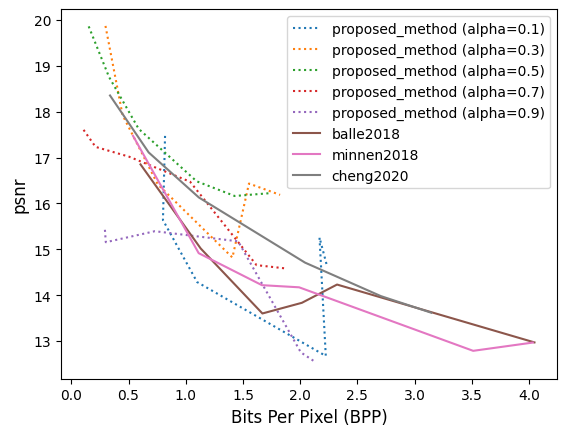

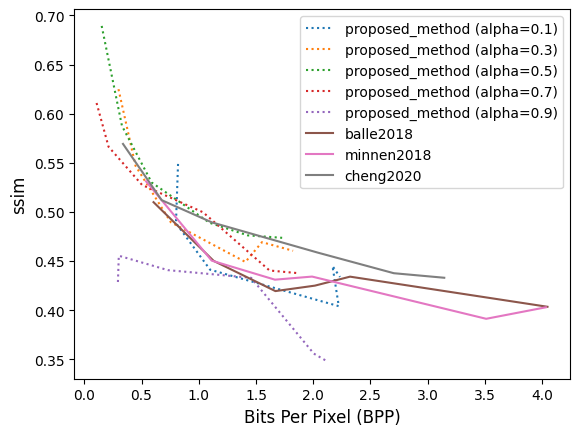

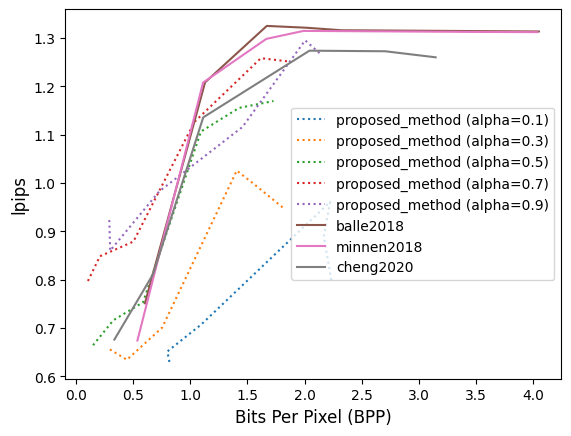

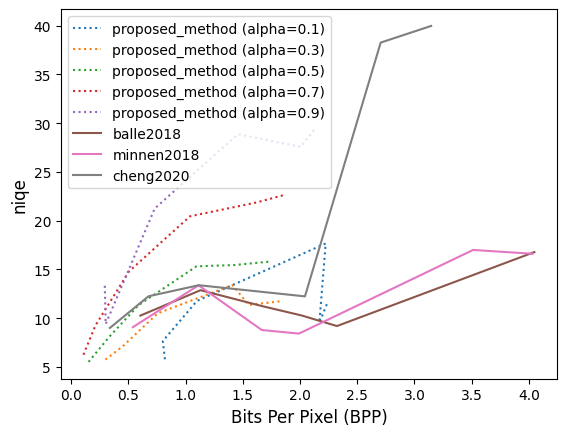

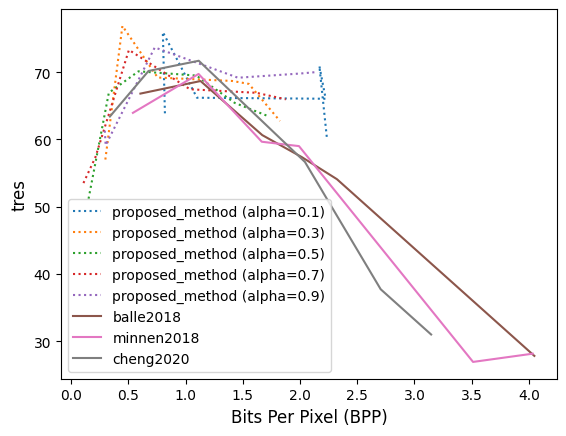

In [8]:
scores = ['psnr', 'ssim', 'lpips','niqe','tres']
for sc in scores:
    for model_name in model_report:
        X = []
        Y = []
        for quality in model_report[model_name]:
            X.append( model_report[model_name][quality]['images_bpp'])
            Y.append( model_report[model_name][quality]['images_'+sc])
        
        if 'proposed_method' in model_name:
            plt.plot(X, Y,linestyle="dotted",label=model_name)
        else:
            plt.plot(X, Y,label=model_name)

    # sheet_data = pd.read_excel(xls,"proposed_method_new")
    # X = sheet_data['bpp'].to_list()
    # Y = sheet_data['ssim'].to_list()
    # plt.plot(X, Y,'--r',label="proposed method")

    # sheet_data = pd.read_excel(xls,"proposed_method_1000")
    # X1 = sheet_data['bpp'].to_list()
    # Y1 = sheet_data['psnr'].to_list()
    # plt.plot(X1, Y1,'--r',label="proposed method")
    plt.xlabel("Bits Per Pixel (BPP)", fontsize=12)
    plt.ylabel(sc, fontsize=12)
    # plt.title("Sigma = 0.5")
    plt.legend()
    plt.savefig('results/guassian_nioise_'+sc+'.png', dpi = 1000)
    plt.show()